In [7]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.nan)
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB

data = pd.read_csv("../Data/preprocessed_balance_perperson_nobril_80-20.csv")
data['Conditie'] = data['Conditie'].map({'norm': 0})
# data

Stratified data

In [8]:
#Code to get X_train, y_train, X_test and y_test for the plots
X = data[['Velocity', 'mean_StepLength', 'Height']]
y = data[['Balance_MeanVelocity_Class']]

#Split the data in training and validation
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), stratify = y, test_size = 0.30)

X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)

#Standardize X components
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Apply dimensionality reduction
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Fit the classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

print(accuracy_score(y_test, y_pred)*100)

78.72340425531915


Confusion matrix, without normalization
[[ 0 10]
 [ 0 37]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


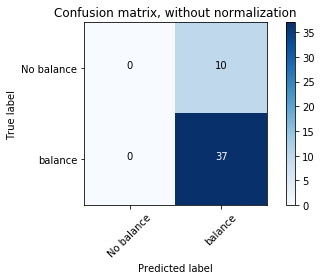

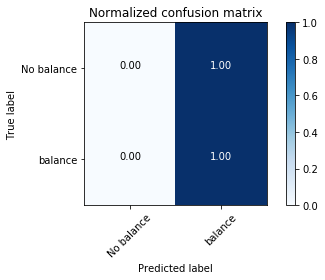

In [9]:
#Plot confusion matrix
class_names = ['No balance', 'balance']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


#Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

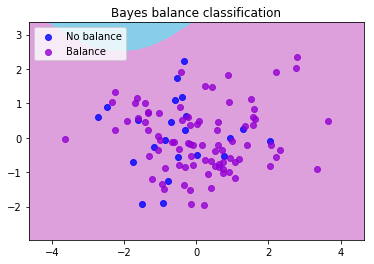

In [10]:
#Plot graph
cmap_background = ListedColormap(['skyblue','plum'])
#Plot the decision boundary
h = .02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_background)

#Plot the test points
colors = ['blue', 'darkviolet']
for label in np.unique(y_train):
    indices = np.where(y_train == label)
    plt.scatter(X_train[indices, 0], X_train[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

#Plot the graph
labels = ['No balance', 'Balance']
plt.legend(labels)
plt.title('Bayes balance classification')
plt.savefig('Bayes_balance_classification')
plt.show()

In [11]:
#Code that loops through the data 100 times and calculates the accuracy for every loop and returns the mean
def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    X = data.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y = data[['Balance_MeanVelocity_Class']]
    
    #Split the test in training and validation
    X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size = 0.30, random_state=0, stratify = y)
    
    X_train = np.array(X_train, dtype=float)
    y_train = np.array(y_train, dtype=int)

    X_test = np.array(X_test, dtype=float)
    y_test = np.array(y_test, dtype=int)

    #Standardize data
    scaler = StandardScaler()

    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #Apply dimensionality reduction
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    #Find optimal k
    error = []
    for i in range(1, 40):  
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test)) 
    j = error.index(min(error)) +1
    
    #Fit the classifier
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_test)

    return f1_score(y_test, y_pred, average="macro", labels=np.unique(y_pred))*100

variable_list = ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'mean_StepLength']
make_decisions(data, variable_list)

88.0952380952381

In [12]:
#Code that prints the F1-scores of varies variable combinations
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('Velocity, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('Velocity, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'Velocity', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('Velocity, mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('Velocity, mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('Velocity, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Velocity, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')

mad_SegmentData, mean_StepLength: 88.1 %.
mean_StepLength, std_SegmentData: 88.1 %.
Velocity, mean_StepLength, mad_SegmentData: 88.1 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 88.1 %.
Velocity, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 88.1 %.
Velocity, mean_StepLength, Height: 88.1 %.
Velocity, mean_StepLength, Age: 88.1 %.
mean_StepLength, Height: 53.67 %.
mean_StepLength, Age: 88.1 %.
Velocity, Height: 88.1 %.
std_SegmentData, Height: 88.1 %.
mad_SegmentData, Age: 88.1 %.
std_SegmentData, Velocity, mean_StepLength: 88.1 %.


Dummy data added

In [13]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.nan)
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

data = pd.read_csv("../Data/preprocessed_balance_perperson_nobril_80-20.csv")
data['Conditie'] = data['Conditie'].map({'norm': 0})
# data

In [14]:
#Code to get X_train, y_train, X_test and y_test for the plots
X = data[['Velocity', 'mean_StepLength', 'Height']]
y = data[['Balance_MeanVelocity_Class']]


#Create dummy data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, np.ravel(y))

#Split the data in training and validation
X_train, X_test, y_train, y_test = train_test_split(X_resampled, np.ravel(y_resampled), test_size = 0.30, random_state=0)

X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)


#Test if dummy data was added
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)


#Standardize X components
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Apply dimensionality reduction
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Fit the classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

print(accuracy_score(y_test, y_pred)*100)

[0 1] [80 90]
51.35135135135135


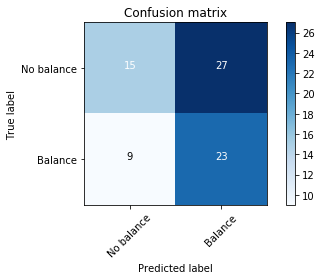

In [15]:
#Plot confusion matrix
class_names = ['No balance', 'Balance']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('Log_reg_confusion_dummy')


#Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure()

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

#Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

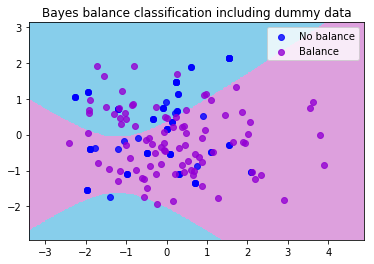

In [16]:
#Plot graph
cmap_background = ListedColormap(['skyblue', 'plum'])
#Plot the decision boundary
h = .02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_background)

#Plot the test points
colors = ['blue', 'darkviolet']
for label in np.unique(y_train):
    indices = np.where(y_train == label)
    plt.scatter(X_train[indices, 0], X_train[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

#Plot the graph
labels = ['No balance', 'Balance']
plt.legend(labels)
plt.title('Bayes balance classification including dummy data')
plt.savefig('Bayes_balance_classification_dummy')
plt.show()

In [17]:
#Code that loops through the data 100 times and calculates the accuracy for every loop and returns the mean
def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    X = data.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y = data[['Balance_MeanVelocity_Class']]

    #Create dummy data
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, np.ravel(y))

    #Split the data in training and validation
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, np.ravel(y_resampled), test_size = 0.30, random_state=0)

    X_train = np.array(X_train, dtype=float)
    y_train = np.array(y_train, dtype=int)

    X_test = np.array(X_test, dtype=float)
    y_test = np.array(y_test, dtype=int)

    #Standardize data
    scaler = StandardScaler()

    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #Apply dimensionality reduction
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    #Fit the classifier
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_test)

    return accuracy_score(y_test, y_pred)*100

variable_list = ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'mean_StepLength']
make_decisions(data, variable_list)

64.86486486486487

In [18]:
#Code that prints the accuracy of varies variable combinations
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('Velocity, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('Velocity, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'Velocity', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('Velocity, mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('Velocity, mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('Velocity, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Velocity, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')

mad_SegmentData, mean_StepLength: 56.76 %.
mean_StepLength, std_SegmentData: 54.05 %.
Velocity, mean_StepLength, mad_SegmentData: 60.81 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 51.35 %.
Velocity, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 56.76 %.
Velocity, mean_StepLength, Height: 51.35 %.
Velocity, mean_StepLength, Age: 58.11 %.
mean_StepLength, Height: 52.7 %.
mean_StepLength, Age: 48.65 %.
Velocity, Height: 60.81 %.
std_SegmentData, Height: 41.89 %.
mad_SegmentData, Age: 62.16 %.
std_SegmentData, Velocity, mean_StepLength: 54.05 %.
